# Test Parallel Processing

In [1]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# or uncomment the code below

#from platform import python_version

#print('The current HDDM version is', python_version())

#import hddm, IPython
#print('The current HDDM version is', hddm.__version__) # 0.8.0

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
#print('The current IPython version is', IPython.__version__) 

Notebook is running: /home/hcp4715/miniconda3/envs/py_ddm/bin/python


In [2]:
!conda list

# packages in environment at /home/hcp4715/miniconda3/envs/py_ddm:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main    conda-forge
attrs                     19.3.0                     py_0    conda-forge
backcall                  0.1.0                    py37_0  
blas                      1.0                         mkl    conda-forge
bleach                    3.1.4                      py_0  
ca-certificates           2020.1.1                      0  
certifi                   2020.4.5.1               py37_0  
cycler                    0.10.0                     py_2    conda-forge
dbus                      1.13.14              hb2f20db_0  
decorator                 4.4.2                      py_0    conda-forge
defusedxml                0.6.0                      py_0    conda-forge
entrypoints               0.3                      py37_0  
expat                     2.2.6                he6710b0_0  
fontco

In [3]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

import random

/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


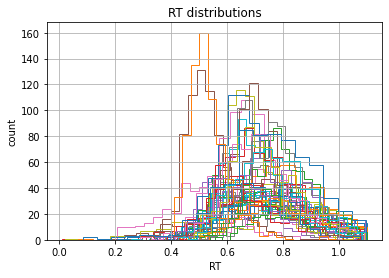

In [4]:
# load data
df1a = hddm.load_csv('df1a.v.hddm_stim.csv')

df1a.head(10)  # uncomment if you want to check the head of the data

# Uncomment the codes below if you are interested in checking the distribution of raw data
# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in df1a.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_MS_dat_M_match.pdf')

In [5]:
# define a function to run model in parallel
def run_model(id):
    print('running model%i'%id);
    
    import hddm
    import random
    
    dbname='df1a_db_test_chain_%i.db'%id
    mname = 'df1a_db_test_chain_%i'%id
    
    df1a = hddm.load_csv('df1a.v.hddm_stim.csv')

    df1a_subj = df1a['subj_idx'].unique()

    # random select without repetition
    random.seed(10)
    df1a_test_list = []
    for i in range(10):
        pos = random.randint(0, (len(df1a_subj)-1))
        df1a_test_list.append(df1a_subj[pos]) 
        #print(df1a_test_list)
    #print(df1a_test_list)  
    
    df1a_test = df1a[df1a['subj_idx'].isin(df1a_test_list)]
    
    m = hddm.HDDMStimCoding(df1a_test, 
                            include='z', 
                            stim_col='stim', 
                            depends_on={'v':['match','val'], 't':['match','val'],'a':['match','val']},
                            split_param='v', 
                            drift_criterion=False,
                            p_outlier=0.05)
    m.find_starting_values()
    m.sample(1000, burn=500, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

### Test single chain

In [9]:
start_time = time.time()  # the start time of the processing

run_model(4)

print("\nRunning 1 chain used: %f seconds." % (time.time() - start_time))

running model4


/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 1001 of 1000 complete in 303.6 sec
Running 1 chain used: 326.935573 seconds.


### Test multiple chains in parallel

In [6]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

# Running 4 chains used: 487.836930 seconds (dell-5510)
# Running 4 chains used: 311.741371 seconds (thinkpad-x1)


Running 4 chains used: 311.741371 seconds.


### Test multiple chain with progress bar

In [ ]:
#-------------------------------
# Watcher function - function for dynamically printing ipython parallel output 
# adapted from the following two sources:
# http://stackoverflow.com/questions/18086299/real-time-output-from-engines-in-ipython-parallel
# http://stackoverflow.com/questions/15289168/printing-to-stdout-in-ipython-parallel-processes
#-------------------------------       
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=60):
    ## ar: vmap output of the models being run
    ## dt: number of seconds between checking output
    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [ ]:
from ipyparallel import Client
start_time = time.time()  # the start time of the processing
v = Client()[:]
jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
# wait_watching_stdout(jobs)
models = jobs.get()

m1_time = time.time() 
print("\nRunning 4 chains used: %f seconds." % (m1_time - start_time))